# NN2: Implementacja propagacji wstecznej błędu
## Laura Hoang, 313366

W ramach tego laboratorium trzeba zaimplementować uczenie sieci neuronowej propagacją wsteczną błędu. Aby sprawdzić implementację, należy wykonać uczenie na prostych danych do uczenia dostarczonych na zajęciach. Następnie należy zaimplementować metodę wizualizacji wartości wag sieci w kolejnych iteracjach i, w przypadku gdy nie udaje się nauczyć sieci, spróbować wykorzystać te wizualizacje do ustalenia przyczyny problemu. Zaimplementować wersję z aktualizacją wag po prezentacji wszystkich wzorców i wersję z aktualizacją po prezentacji kolejnych porcji (batch). Porównać szybkość uczenia dla każdego z wariantów.

Inicjować wagi z rozkładu jednostajnego na przedziale [0,1]. Opcjonalnie zaimplementować inną metodą inicjowania wag. Albo metodę He albo Xavier.

Przetestować uczenie sieci na następujących zbiorach (w nawiasach wartość MSE, aby otrzymać 4 punkty):
- square-simple (jeśli sieć nie jest w stanie się nauczyć tej funkcji to coś jest bardzo źle zrobione, MSE: 4),
- steps-small (MSE: 4),
- multimodal-large (MSE: 40).
(Wartości MSE liczone na nieznormalizowanych danych)

Pracę rozpoczynamy od zaimportowania odpowiednich bibliotek.

In [1]:
import pandas as pd
import numpy as np
from numpy import exp, dot, square, subtract
from scipy.special import expit

from matplotlib import pyplot as plt

np.random.seed(420)

## Implementacja sieci (NN1 + propagacja wsteczna)

In [2]:
# funkcja aktywacji
def sigmoid(x):
    return expit(x)


# pochodna funkcji aktywacji
def sigmoid_der(x):
    return sigmoid(x) * (1 - sigmoid(x))


class NeuralNetwork():
    def __init__(self, number_of_neurons=[], activation=sigmoid, activation_der=sigmoid_der, initiate_w_b="Uniform", visualize_weights=False):
        self.number_of_neurons = number_of_neurons  # liczba neuronów w każdej warstwie (wliczając wejście i wyjście)
        self.synaptic_weights = []                  # lista z wagami
        self.biases = []                            # lista biasów

        self.activation = activation                # funkcja aktywacji
        self.activation_der = activation_der        # pochodna funkcji aktywacji

        if initiate_w_b == "Xavier":
            self.weights_xavier(number_of_neurons)
        else:
            self.weights_uniform(number_of_neurons)

        self.visualize_weights = visualize_weights


    def weights_uniform(self, number_of_neurons):
        for i in range(len(self.number_of_neurons) - 1):
            self.synaptic_weights += [np.random.uniform(-1, 1, self.number_of_neurons[i] * self.number_of_neurons[i + 1]).reshape(number_of_neurons[i], self.number_of_neurons[i + 1])]
            self.biases += [np.random.uniform(-1, 1, self.number_of_neurons[i + 1]).reshape(1, self.number_of_neurons[i+1])]


    def weights_xavier(self, number_of_neurons):
        xavier = np.sqrt(6)/np.sqrt(self.number_of_neurons[1]+self.number_of_neurons[-1])
        for i in range(len(self.number_of_neurons) - 1):
            self.synaptic_weights += [xavier * np.random.uniform(-1, 1, self.number_of_neurons[i] * self.number_of_neurons[i + 1]).reshape(number_of_neurons[i], self.number_of_neurons[i + 1])]
            self.biases += [xavier * np.random.uniform(-1, 1, self.number_of_neurons[i + 1]).reshape(1, self.number_of_neurons[i+1])]


    def mse(self, y, y_hat):
        return square(subtract(y, y_hat)).mean()


    def forward(self, input):
        self.A = []
        self.z = []

        self.A += [input]
        a = input

        number_of_hidden_layers = len(self.number_of_neurons)-2
        for layer in range(number_of_hidden_layers):
            output = dot(a, self.synaptic_weights[layer]) + self.biases[layer]
            self.z += [output]
            a = self.activation(output)
            self.A += [a]

        result = dot(a,self.synaptic_weights[-1]) + self.biases[-1]

        self.z += [result]
        self.A += [result]

        return result


    # propagacja wsteczna
    def backward(self, y):
        m = y.shape[0]
        D = [None] * len(self.synaptic_weights)
        D[-1] = y - self.A[-1]

        for i in reversed(range(len(D) - 1)):
            D[i] = (dot(self.synaptic_weights[i + 1], D[i + 1].T) * self.activation_der(self.z[i]).T).T

        delta_w = [None] * len(D)
        delta_b = [None] * len(D)

        for i, d in enumerate(D):
            delta_w[i] = dot(d.T, self.A[i]).T / m
            delta_b[i] = dot(d.T, np.ones((m, 1))).T / m

        return (delta_w, delta_b)


    def learn(self, x, y, batch_size=20, iterations=500, alpha=0.01):
        # batchowe uczenie modelu, dla batch_size=1 mamy cały zbiór
        # alpha - learning rate
        
        p = np.random.permutation(len(x))
        x = x[p]
        y = y[p]

        self.errors = []

        for iteration in range(iterations):
            i = 0
            while i < len(y):
                x_batch = x[i : i+batch_size]
                y_batch = y[i : i+batch_size]

                i += batch_size
                self.forward(x_batch)
                (delta_w, delta_b) = self.backward(y_batch)

                for j, weight in enumerate(self.synaptic_weights):
                    self.synaptic_weights[j] = weight + alpha * delta_w[j]
                
                for j, bias in enumerate(self.biases):
                    self.biases[j] = bias + alpha * delta_b[j]

            # BADANIE SKUTECZNOŚCI MODELU DLA KOLEJNYCH ITERACJI (epoch)
            if self.visualize_weights:
                # error = self.mse(self.A[-1], y_batch)
                error = np.linalg.norm(self.A[-1] - y_batch)
                if iteration % 50 == 0:
                    print("Error in epoch {} = {}".format(iteration, error))
                self.errors += [error]
            else:
                print(f"Custom error in epoch {iteration} = { np.abs(y_batch -  self.A[-1]).mean()}", end='\r')

        if self.visualize_weights:
            df=pd.DataFrame({'epoch': range(iterations), 'error': self.errors})
            plt.plot( 'epoch', 'error', data=df, markerfacecolor='pink', linewidth=1)
            plt.legend()
            plt.show()




## Pierwszy zbiór danych (*square simple*)

Error in epoch 0 = 225.3945599773405
Error in epoch 50 = 5.1037838665443696
Error in epoch 100 = 3.559299927086744
Error in epoch 150 = 3.164622363876751
Error in epoch 200 = 2.992091518468185
Error in epoch 250 = 2.8576308225430673
Error in epoch 300 = 2.7310625996081024
Error in epoch 350 = 2.6095380252706626
Error in epoch 400 = 2.4937986125973874
Error in epoch 450 = 2.3844859581685425
Error in epoch 500 = 2.281836567160416
Error in epoch 550 = 2.1858024669658023
Error in epoch 600 = 2.096165222438863
Error in epoch 650 = 2.012611125786451
Error in epoch 700 = 1.9347796208381869
Error in epoch 750 = 1.8622946647631762
Error in epoch 800 = 1.7947845632607637
Error in epoch 850 = 1.7318936717978548
Error in epoch 900 = 1.6732883708861248
Error in epoch 950 = 1.6186591750719073


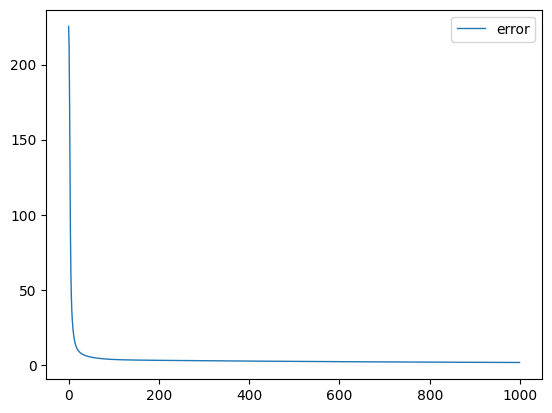

MSE:  0.5506052708023392


In [86]:
number_of_neurons=[1, 400, 1]

train_df = pd.read_csv('square-simple-training.csv', index_col=0)
test_df = pd.read_csv('square-simple-test.csv', index_col=0)

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)
x_test = np.asarray(test_df['x']).reshape(-1, 1)
y_test = np.asarray(test_df['y']).reshape(-1, 1)

nn = NeuralNetwork(number_of_neurons = number_of_neurons, visualize_weights=True)
nn.learn(x, y, iterations=1000, batch_size = 5, alpha=0.01)
y_pred = nn.forward(x_test)
errors_batch = nn.errors

print('MSE: ', nn.mse(y_test, y_pred))


Error in epoch 0 = 16.776373383073988
Error in epoch 50 = 0.9662571719534441
Error in epoch 100 = 0.8512973977242808
Error in epoch 150 = 0.09228718050344753
Error in epoch 200 = 0.14467804284940655
Error in epoch 250 = 0.11709120672774986
Error in epoch 300 = 0.08388792596865358
Error in epoch 350 = 0.057767535160891725
Error in epoch 400 = 0.03620707818056701
Error in epoch 450 = 0.007510648030631728
Error in epoch 500 = 0.006676522371250826
Error in epoch 550 = 0.16136288017530376
Error in epoch 600 = 0.19234263709749655
Error in epoch 650 = 0.20389294686303572
Error in epoch 700 = 0.20944158880199382
Error in epoch 750 = 0.20874808934262035
Error in epoch 800 = 0.20856032250704004
Error in epoch 850 = 0.2135383679880789
Error in epoch 900 = 0.2300373572517742
Error in epoch 950 = 0.2513781478812831


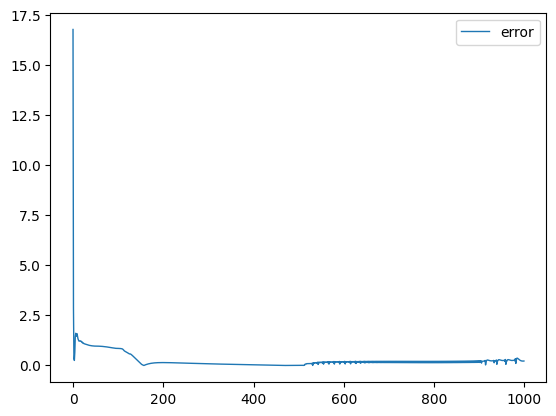

MSE:  13.904363034415036


In [90]:
number_of_neurons=[1, 400, 1]

train_df = pd.read_csv('square-simple-training.csv', index_col=0)
test_df = pd.read_csv('square-simple-test.csv', index_col=0)

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)
x_test = np.asarray(test_df['x']).reshape(-1, 1)
y_test = np.asarray(test_df['y']).reshape(-1, 1)

nn = NeuralNetwork(number_of_neurons = number_of_neurons, visualize_weights=True)
nn.learn(x, y, iterations=1000, batch_size = 1, alpha=0.01)
y_pred = nn.forward(x_test)
errors_all = nn.errors

print('MSE: ', nn.mse(y_test, y_pred))

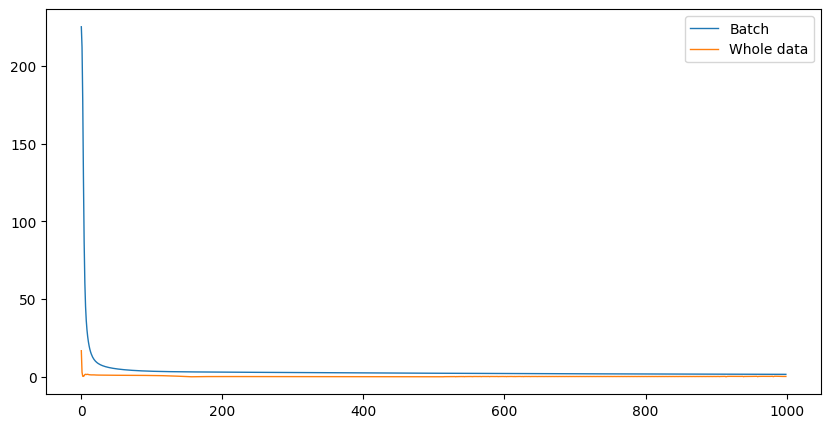

In [91]:
df=pd.DataFrame({'x_values': range(1000), 'Batch': errors_batch, 'Whole data': errors_all})
plt.figure(figsize=(10,5))
plt.plot( 'x_values', 'Batch', data=df, linewidth=1)
plt.plot( 'x_values', 'Whole data', data=df, linewidth=1)
plt.legend()


## Drugi zbiór danych (*steps small*)

Error in epoch 0 = 337.27445573241414
Error in epoch 50 = 177.2052957657765
Error in epoch 100 = 172.0564521864473
Error in epoch 150 = 113.40859781404211
Error in epoch 200 = 93.11570433401361
Error in epoch 250 = 67.31017251602107
Error in epoch 300 = 88.34756401260083
Error in epoch 350 = 88.79926734175713
Error in epoch 400 = 32.88562442047709
Error in epoch 450 = 7.667937156095824
Error in epoch 500 = 2.7424522441530037
Error in epoch 550 = 1.5982180522519889
Error in epoch 600 = 1.28945834424372
Error in epoch 650 = 1.1863261305382353
Error in epoch 700 = 1.1346717938607753
Error in epoch 750 = 1.0978140910449545
Error in epoch 800 = 1.0666911042219172
Error in epoch 850 = 1.0387467065421119
Error in epoch 900 = 1.013075475384046
Error in epoch 950 = 0.9892517365965255


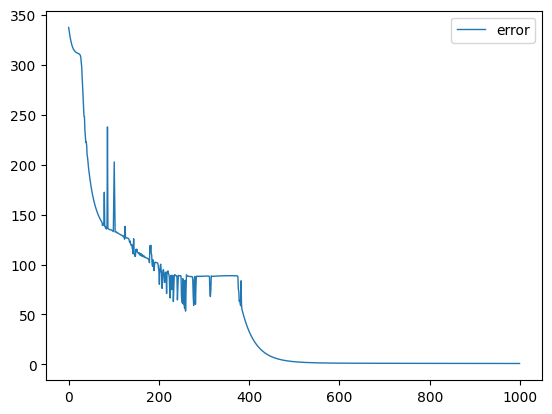

MSE:  70.75895213612138


In [69]:
number_of_neurons=[1, 10, 10, 10, 10, 1]

train_df = pd.read_csv('steps-small-training.csv', index_col=0)
test_df = pd.read_csv('steps-small-test.csv', index_col=0)

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)
x_test = np.asarray(test_df['x']).reshape(-1, 1)
y_test = np.asarray(test_df['y']).reshape(-1, 1)

nn = NeuralNetwork(number_of_neurons = number_of_neurons, visualize_weights=True)
nn.learn(x, y, iterations=1000, batch_size = 40, alpha=0.01)
y_pred = nn.forward(x_test)
errors_batch = nn.errors

print('MSE: ', nn.mse(y_test, y_pred))


Error in epoch 0 = 83.93307612628011
Error in epoch 50 = 94.74144577549218
Error in epoch 100 = 94.74287797684126
Error in epoch 150 = 94.74327140555584
Error in epoch 200 = 94.74344316705111
Error in epoch 250 = 94.7435283131415
Error in epoch 300 = 94.74356298384016
Error in epoch 350 = 94.74354853065743
Error in epoch 400 = 94.74343627411318
Error in epoch 450 = 94.74271381699073
Error in epoch 500 = 90.0136354236785
Error in epoch 550 = 93.09962839187331
Error in epoch 600 = 94.57063825896977
Error in epoch 650 = 94.74382226668465
Error in epoch 700 = 94.74385527372324
Error in epoch 750 = 94.74387448578098
Error in epoch 800 = 94.74388757964842
Error in epoch 850 = 94.7438972479441
Error in epoch 900 = 94.74390475330193
Error in epoch 950 = 94.74391078588584


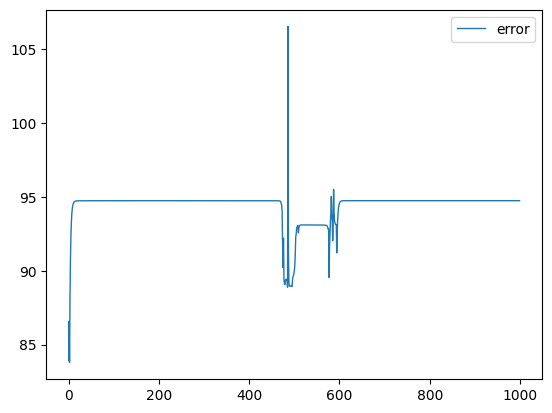

MSE:  7592.113598533731


In [70]:
number_of_neurons=[1, 10, 10, 10, 10, 1]

train_df = pd.read_csv('steps-small-training.csv', index_col=0)
test_df = pd.read_csv('steps-small-test.csv', index_col=0)

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)
x_test = np.asarray(test_df['x']).reshape(-1, 1)
y_test = np.asarray(test_df['y']).reshape(-1, 1)

nn = NeuralNetwork(number_of_neurons = number_of_neurons, visualize_weights=True)
nn.learn(x, y, iterations=1000, batch_size = 1, alpha=0.01)
y_pred = nn.forward(x_test)
errors_all = nn.errors

print('MSE: ', nn.mse(y_test, y_pred))

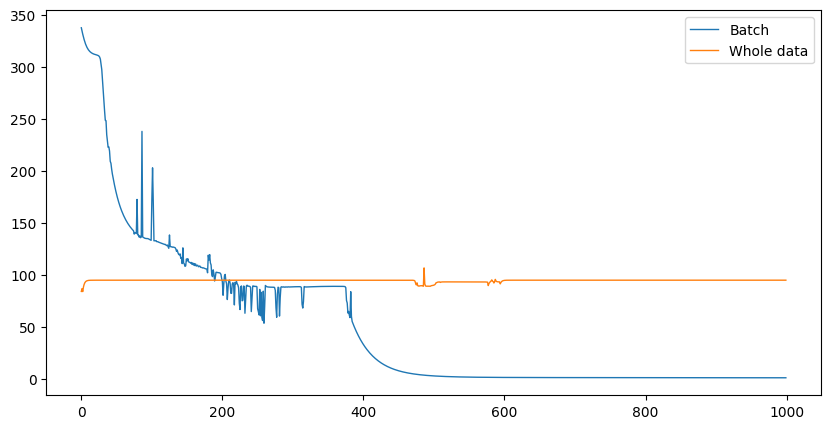

In [71]:
df=pd.DataFrame({'x_values': range(1000), 'Batch': errors_batch, 'Whole data': errors_all})
plt.figure(figsize=(10,5))
plt.plot( 'x_values', 'Batch', data=df, linewidth=1)
plt.plot( 'x_values', 'Whole data', data=df, linewidth=1)
plt.legend()


## Trzeci zbiór danych (*multimodal large*)

Error in epoch 0 = 149.02455715468827
Error in epoch 50 = 4.893990858613333
Error in epoch 100 = 2.046940836243326
Error in epoch 150 = 1.3727486445681196
Error in epoch 200 = 0.9558538975174722
Error in epoch 250 = 0.9058987534369524
Error in epoch 300 = 1.6566319090372534
Error in epoch 350 = 1.2487316160561186
Error in epoch 400 = 9.619425303825002
Error in epoch 450 = 7.819011777643158
Error in epoch 500 = 0.2579401753379278
Error in epoch 550 = 2.0641240244573074
Error in epoch 600 = 7.801247276213317
Error in epoch 650 = 1.154465288936422
Error in epoch 700 = 12.573973349402962
Error in epoch 750 = 3.1067723170513615
Error in epoch 800 = 10.049222982670729
Error in epoch 850 = 1.9803785903397602
Error in epoch 900 = 1.6670881297398508
Error in epoch 950 = 1.337060175862245


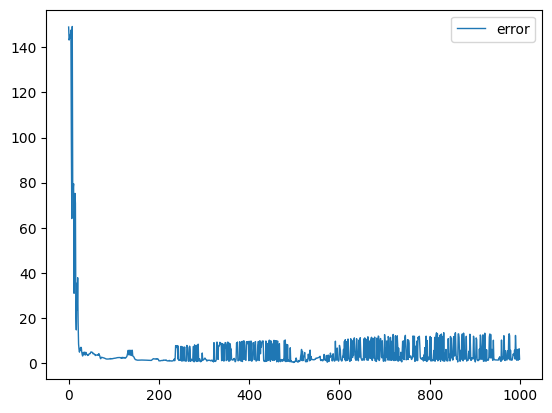

MSE:  1.9839809164903819


In [3]:
number_of_neurons=[1, 50, 50, 50, 1]

train_df = pd.read_csv('multimodal-large-training.csv')
test_df = pd.read_csv('multimodal-large-test.csv')

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)
x_test = np.asarray(test_df['x']).reshape(-1, 1)
y_test = np.asarray(test_df['y']).reshape(-1, 1)

nn = NeuralNetwork(number_of_neurons = number_of_neurons, visualize_weights=True)
nn.learn(x, y, iterations=1000, batch_size = 30, alpha=0.01)
y_pred = nn.forward(x_test)
errors_batch = nn.errors

print('MSE: ', nn.mse(y_test, y_pred))

In [4]:
number_of_neurons=[1, 50, 50, 50, 1]

train_df = pd.read_csv('multimodal-large-training.csv')
test_df = pd.read_csv('multimodal-large-test.csv')

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)
x_test = np.asarray(test_df['x']).reshape(-1, 1)
y_test = np.asarray(test_df['y']).reshape(-1, 1)

nn = NeuralNetwork(number_of_neurons = number_of_neurons, visualize_weights=True)
nn.learn(x, y, iterations=1000, batch_size = 1, alpha=0.01)
y_pred = nn.forward(x_test)
errors_all = nn.errors

print('MSE: ', nn.mse(y_test, y_pred))

Error in epoch 0 = 51.5256645610898
Error in epoch 50 = 55.31211753817809
Error in epoch 100 = 56.23286961094016
Error in epoch 150 = 54.19343960090855
Error in epoch 200 = 52.92014795549304
Error in epoch 250 = 51.52574160593136
Error in epoch 300 = 51.52574157606788
Error in epoch 350 = 51.525741557140776
Error in epoch 400 = 51.525741543281875
Error in epoch 450 = 51.52574153203589
Error in epoch 500 = 51.52574152209122


KeyboardInterrupt: 

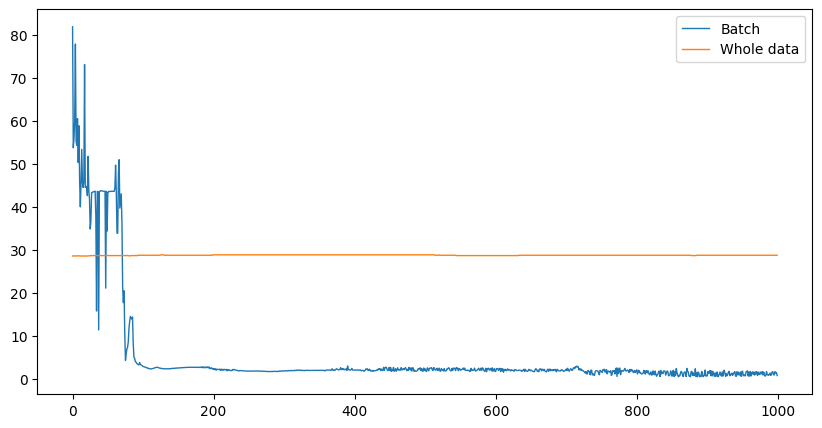

In [ ]:
df=pd.DataFrame({'x_values': range(1000), 'Batch': errors_batch, 'Whole data': errors_all})
plt.figure(figsize=(10,5))
plt.plot( 'x_values', 'Batch', data=df, linewidth=1)
plt.plot( 'x_values', 'Whole data', data=df, linewidth=1)
plt.legend()


## Podsumowanie
| Zbiór danych    | Architektura    | MSE (test)   | MSE (train)     |
|---------------|--------|--------|---------|
| square-simple | 1-400-1 | ~0 | ~0 |
| steps-small   | 1-10-10-10-10-1 | ~50 | ~0 |
| multimodal-large   | 1-50-50-50-1 | ~1.5 | ~5 |

Udało mi się nauczyć wszystkie modele, co widać po wizualizacjach. Nie zdołałam jedynie na tyle dobrze dobrać architektury do zbioru `steps-small`, aby otrzymać MSE<4. Jednak wykresy pokazują, iż model nadal dosyć sensownie dobiera parametry.
